Dropdown(description='Provider:', options=('AWS', 'OpenAI'), value='AWS')

Enter ingredients:  white chocolate, peppermint, cream, sugar
Enter Items to Avoid:  sugar
Enter Dietary Constraints:  gluten free


{'cooking_time': '20',
 'dietary_constraints': 'gluten free',
 'difficulty': 'Easy',
 'ingredients': [{'amount': '8',
                  'item': 'White chocolate',
                  'measure': 'ounces'},
                 {'amount': '1', 'item': 'Heavy cream', 'measure': 'cup'},
                 {'amount': '1/2',
                  'item': 'Peppermint extract',
                  'measure': 'teaspoon'},
                 {'amount': '2', 'item': 'Stevia', 'measure': 'tablespoons'}],
 'instructions': ['Melt the white chocolate in a double boiler or microwave, '
                  'stirring until smooth.',
                  'In a separate bowl, whip the heavy cream until stiff peaks '
                  'form.',
                  'Gently fold the melted white chocolate into the whipped '
                  'cream.',
                  'Add the peppermint extract and stevia, folding until well '
                  'combined.',
                  'Divide the mixture into serving glasses or bowls.',
  

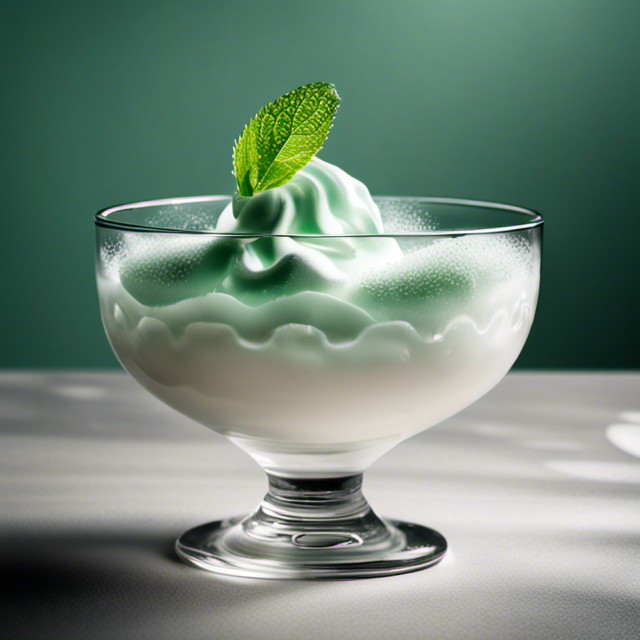

In [1]:
import boto3
from botocore.exceptions import ClientError
import json
import re
import random
import base64
from PIL import Image
import io
import pprint
import logging
from IPython.display import Image as IPImage
from IPython.display import display, HTML
import openai
from abc import ABC, abstractmethod
import os
import ipywidgets as widgets

class RecipeGeneratorInterface(ABC):
    @abstractmethod
    def generate_recipe(self, ingredients, items_to_avoid, dietary_constraints, debug=False):
        pass

    @abstractmethod
    def generate_image(self, recipe_name, recipe_descrip):
        pass

    def extract_json(self, response):
        # Find JSON content between triple backticks
        json_match = re.search(r'```json\n(.*?)```', response, re.DOTALL)
        if json_match:
            #return json.loads(json_match.group(1))
            return json_match.group(1)
        return None
        
class AWSRecipeGenerator(RecipeGeneratorInterface):
    def __init__(self, region_name='us-east-1'):
        self.bedrock = boto3.client('bedrock-runtime', region_name=region_name)

    def generate_recipe(self, ingredients, items_to_avoid, dietary_constraints, debug=False):
        user_message = f"""Create a recipe using these ingredients: {ingredients}.
                          Conform the recipe to listed dietary constraints: {dietary_constraints}.
                          Items to avoid using in this recipe due to sensitivities or allergies: {items_to_avoid}.
                          Ensure the recipe_image_description is hyper detailed for use as an image generation prompt.
                          Format as JSON with all fields quoted and ingredients with the first letter capitalized: name,
                                                    ingredients list({{item, amount, measure}}),
                                                    instructions (list),
                                                    cooking_time (minutes),
                                                    difficulty,
                                                    recipe_description,
                                                    recipe_image_description,
                                                    dietary_constraints: {dietary_constraints}"""
        
        conversation = [
            {
                "role": "user",
                "content": [{'text': user_message}],
            }
        ]
        
        try:
            modelId = 'anthropic.claude-3-5-sonnet-20240620-v1:0'
            response = self.bedrock.converse(
                modelId=modelId,
                messages=conversation,
                inferenceConfig={'maxTokens': 2000, 'temperature': 0.5, 'topP': 0.7},
            )
            recipe = json.loads(response['output']['message']['content'][0]['text'])
            if debug:
                pprint.pprint(recipe)
            return recipe
        except (ClientError, Exception) as e:
            print(f"ERROR: Can't invoke '{modelId}'. Reason: {e}")
            raise

    def generate_image(self, recipe_name, recipe_descrip):
        prompt = f"""A professional food photography shot of {recipe_descrip}. Done with studio lighting."""
        seed = random.randint(0, 4294967295)
        
        try:
            response = self.bedrock.invoke_model(
                modelId='stability.stable-diffusion-xl-v1',
                body=json.dumps({
                    'text_prompts': [{'text': prompt}],
                    'style_preset': 'photographic',
                    'seed': seed,
                    'height': 640,
                    'width': 640,
                    'cfg_scale': 7,
                    'steps': 150,
                })
            )
            
            model_response = json.loads(response['body'].read())
            return model_response['artifacts'][0]['base64']
        except Exception as e:
            print(f"Error generating image: {e}")
            raise

class OpenAIRecipeGenerator(RecipeGeneratorInterface):
    def __init__(self, api_key):
        self.client = openai.OpenAI(api_key=api_key)

    def generate_recipe(self, ingredients, items_to_avoid, dietary_constraints, debug=False):
        prompt = f"""Create a recipe using these ingredients: {ingredients}.
                    Conform the recipe to listed dietary constraints: {dietary_constraints}.
                    Items to avoid using in this recipe due to sensitivities or allergies: {items_to_avoid}.
                    Ensure the recipe_image_description is hyper detailed for use as an image generation prompt.
                    Format as JSON with all fields quoted and ingredients with the first letter capitalized: name,
                                                ingredients list({{item, amount, measure}}),
                                                instructions (list),
                                                cooking_time (minutes),
                                                difficulty,
                                                recipe_description,
                                                recipe_image_description,
                                                dietary_constraints: {dietary_constraints}"""

        try:
            response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.7
            )

            if debug:
                sep =  print("-"*80)
                print(response)
                print(sep)
                print(response.choices[0].message.content)
                print(sep)
                print(self.extract_json(response.choices[0].message.content))
                print(sep)
            
            recipe = json.loads(self.extract_json(response.choices[0].message.content))
            if debug:
                pprint.pprint(recipe)
                
            return recipe
        except Exception as e:
            print(f"Error generating recipe: {e}")
            raise

    def generate_image(self, recipe_name, recipe_descrip):
        prompt = f"A professional food photography shot of {recipe_descrip}. Done with studio lighting."
        
        try:
            response = self.client.images.generate(
                model="dall-e-3",
                prompt=prompt,
                size="1024x1024",
                quality="standard",
                n=1,
            )
            
            # Download the image and convert to base64
            import requests
            image_url = response.data[0].url
            image_response = requests.get(image_url)
            image_data = base64.b64encode(image_response.content).decode('utf-8')
            return image_data
        except Exception as e:
            print(f"Error generating image: {e}")
            raise

class RecipeGeneratorApp:
    def __init__(self, generator: RecipeGeneratorInterface):
        self.generator = generator

    def display_recipe(self, recipe, image_data):
        html = f"""
            <h1>{recipe['name']}</h1>
            <h3>{recipe['recipe_description']}</h3>
            <div style='margin: 20px 0;'>
                <h3>Ingredients:</h3>
                <ul>
                    {''.join(f"<li>{ingredient['item']} {ingredient['amount']} {ingredient['measure']}</li>" for ingredient in recipe['ingredients'])}
                </ul>
            </div>
            <div style='margin: 20px 0;'>
                <h3>Instructions:</h3>
                <ol>
                    {''.join(f'<li>{instruction}</li>' for instruction in recipe['instructions'])}
                </ol>
            </div>
            <div>
                <p>Cooking Time: {recipe['cooking_time']} minutes</p>
                <p>Difficulty: {recipe['difficulty']}</p>
                <p>Dietary Constraints: {recipe['dietary_constraints']}</p>
            </div>
        """

        try:
            # Decode base64 to bytes
            image_bytes = base64.b64decode(image_data)
            # Create IPython Image object
            img = IPImage(data=image_bytes)
            # Display image with some styling
            display(HTML('''<div style="text-align: center; margin: 20px auto; max-width: 800px;">
                                <div style="max-width: 800px; margin: 20px auto; font-family: Arial;">'''))
            display(HTML(html))
            display(HTML("<div>"))
            display(img)
            display(HTML("</div>"))
            display(HTML('''    </div>
                            </div>'''))
        except Exception as e:
            print(f"Error displaying image: {e}")

    def generate_recipe_with_image(self, ingredients, items_to_avoid, dietary_constraints, debug=False):
        recipe = self.generator.generate_recipe(ingredients, items_to_avoid, dietary_constraints, debug)
        image = self.generator.generate_image(recipe['name'], recipe['recipe_image_description'])
        self.display_recipe(recipe, image)
        return recipe, image

def create_generator(provider: str, **kwargs):
    """Factory function to create appropriate generator based on provider"""
    if provider.lower() == 'aws':
        return AWSRecipeGenerator(**kwargs)
    elif provider.lower() == 'openai':
        return OpenAIRecipeGenerator(**kwargs)
    else:
        raise ValueError(f"Unsupported provider: {provider}")
    
def on_selection_change(change):
    print(f"Selected value: {change.new}")
    
# Example usage:
if __name__ == "__main__":
  
    dropdown = widgets.Dropdown(
        options=['AWS', 'OpenAI'],
        value='AWS',
        description='Provider:',
    )
    dropdown.observe(on_selection_change, names='value')
    display(dropdown)

    if dropdown == "OpenAI":
        api_key = os.getenv("OPENAI_API_KEY")
        if not api_key:
            raise ValueError("OpenAI API key not found. Please set the OPENAI_API_KEY environment variable.")
        app = RecipeGeneratorApp(create_generator('openai', api_key=api_key))
    else:  # AWS
        app = RecipeGeneratorApp(create_generator('aws', region_name='us-east-1'))

    #ingredients = 'pork, carrots, zucchini, cream of mushroom soup'
    #items_to_avoid = 'Noodles'
    # ingredients = 'white chocolate, peppermint, cream, sugar'
    # items_to_avoid = 'Nuts'
    # dietary_constraints = 'Gluten Free'

    ingredients = input('Enter ingredients: ')
    items_to_avoid = input('Enter Items to Avoid: ')
    dietary_constraints = input('Enter Dietary Constraints: ')
    
    app.generate_recipe_with_image(ingredients, items_to_avoid, dietary_constraints, debug=True)
    
